In [1]:
%load_ext autoreload
%autoreload 2

# imports

In [108]:
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
from scipy.stats import norm, rayleigh, gamma
from tools import get_mids
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
matplotlib = sns.mpl
plt = matplotlib.pyplot
plt.style.use("../style.mplstyle")
warnings.filterwarnings("ignore")

# load data

In [118]:
fisher = pd.read_pickle("../resources/fisher_casc.pickle")
# give a name to the first index
fisher.index.names = ['config', 'spacing', 'energy', 'pmts']

In [119]:
fisher

x         y  \
config                  spacing energy        pmts                        
Full optimistic triang  50.0    1000.000000   16     1.352739  0.703857   
                                              20     1.012067  0.637069   
                                              24     0.942791  0.535503   
                                3162.277660   16     0.707869  0.342387   
                                              20     0.493276  0.321912   
...                                                       ...       ...   
Full pessimistic triang 200.0   100000.000000 20    12.182048  7.256502   
                                              24    11.086242  6.215335   
                                316227.766017 16     7.194615  4.748942   
                                              20     6.147630  3.551338   
                                              24     5.169241  2.979987   

                                                           z    stheta  \
config                  spacing energy        pmts                       
Full optimistic triang  50.0    1000.000000   16    0.559729  0.049481   
                                              20    0.464704  0.040069   
                                              24    0.385330  0.037156   
                                3162.277660   16    0.275615  0.026889   
                                              20    0.216154  0.021130   
...                                                      ...       ...   
Full pessimistic triang 200.0   100000.000000 20    1.974188  0.117641   
                                              24    1.694111  0.107730   
                                316227.766017 16    1.060124  0.072736   
                                              20    0.951684  0.064724   
                                              24    0.832194  0.058203   

                                                        sphi         t  \
config                  spacing energy        pmts                       
Full optimistic triang  50.0    1000.000000   16    0.154299  1.723374   
                                              20    0.133711  1.445467   
                                              24    0.123173  1.187608   
                                3162.277660   16    0.085099  0.866455   
                                              20    0.069441  0.762709   
...                                                      ...       ...   
Full pessimistic triang 200.0   100000.000000 20    0.723334  8.965950   
                                              24    0.640616  7.900044   
                                316227.766017 16    0.430284  5.026051   
                                              20    0.407114  4.415720   
                                              24    0.393804  3.921338   

                                                        logE  ang_res_sampl  \
config                  spacing energy        pmts                            
Full optimistic triang  50.0    1000.000000   16    0.060975       3.955554   
                                              20    0.053944       3.322063   
                                              24    0.048278       2.993003   
                                3162.277660   16    0.033501       2.098690   
                                              20    0.029657       1.788490   
...                                                      ...            ...   
Full pessimistic triang 200.0   100000.000000 20    0.106407      10.203195   
                                              24    0.094693       9.312985   
                                316227.766017 16    0.063664       6.413332   
                                              20    0.057363       5.368697   
                                              24    0.051617       4.804440   

                                                    theta_deg    phi_deg  \
config                  spacing energy        pmts    

In [141]:
series.logE.values

array([0.06097529, 0.0335007 , 0.01851028, 0.00978501, 0.0052126 ,
       0.00284676], dtype=float32)

In [143]:
series.index.get_level_values(2).values

array([  1000.        ,   3162.27766017,  10000.        ,  31622.77660168,
       100000.        , 316227.76601684])

In [132]:
for ident, series in fisher.groupby(['config', 'spacing', 'pmts']):
    print(ident)
    print(series)
    st = ""
    for val, name in zip(ident, ['config', 'spacing', 'pmts']):
        st += ": ".join([name, str(val)]) + ", "
    print(st)
    break
    


('Full optimistic triang', 50.0, 16)
                                                          x         y  \
config                 spacing energy        pmts                       
Full optimistic triang 50.0    1000.000000   16    1.352739  0.703857   
                               3162.277660   16    0.707869  0.342387   
                               10000.000000  16    0.347211  0.175341   
                               31622.776602  16    0.161065  0.084571   
                               100000.000000 16    0.044788  0.030905   
                               316227.766017 16    0.016422  0.012673   

                                                          z    stheta  \
config                 spacing energy        pmts                       
Full optimistic triang 50.0    1000.000000   16    0.559729  0.049481   
                               3162.277660   16    0.275615  0.026889   
                               10000.000000  16    0.136333  0.015157   
             

('Full optimistic triang', 50.0, 16)
config: Full optimistic triang, spacing: 50.0, pmts: 16, 


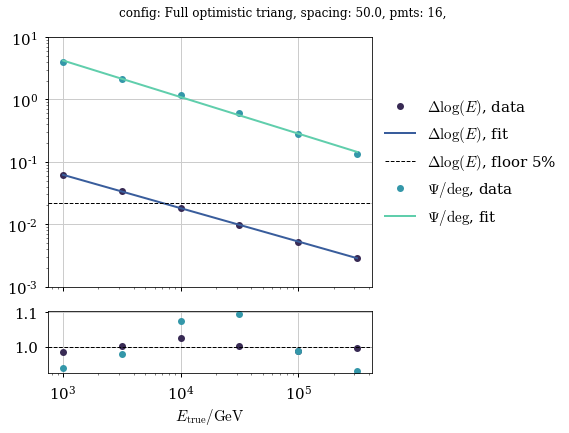

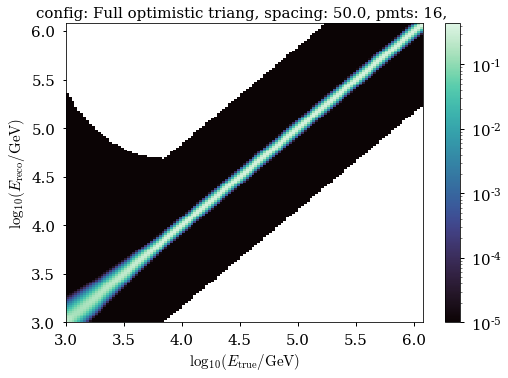

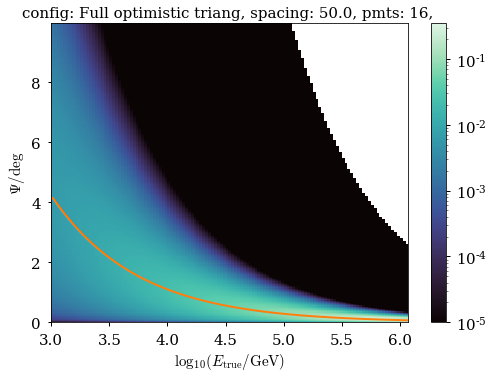

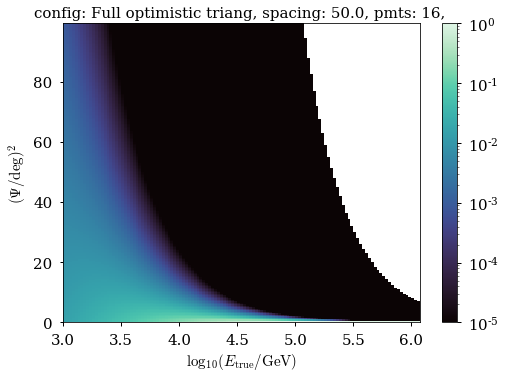

In [148]:
for ident, series in fisher.groupby(['config', 'spacing', 'pmts']):
    print(ident)
    ident_str = ""
    for val, name in zip(ident, ['config', 'spacing', 'pmts']):
        ident_str += ": ".join([name, str(val)]) + ", "
    print(ident_str)
    true_E = series.index.get_level_values(2).values
    width_E = series.logE.values
    width_psi = series.ang_res_sampl.values
    width_E_floor = 0.05 / np.log(10)

    # interpolate
    fig = plt.figure(figsize=(8, 6))
    fig.suptitle(ident_str)

    gs = GridSpec(2, 1, height_ratios=[4, 1])
    ax1 = fig.add_subplot(gs[0])

    # energy width
    fit_we = np.poly1d(np.polyfit(np.log10(true_E), np.log10(width_E), 1))
    p1 = ax1.plot(true_E, width_E, marker="o", lw=0, label=r"$\Delta \log(E)$, data")
    ax1.plot(true_E, 10 ** fit_we(np.log10(true_E)), label=r"$\Delta \log(E)$, fit")
    ax1.axhline(
        width_E_floor, label=r"$\Delta \log(E)$, floor 5%", color="k", ls="--", lw=1
    )

    # psi
    fit_wps = np.poly1d(np.polyfit(np.log10(true_E), np.log10(width_psi), 1))
    p2 = ax1.plot(true_E, width_psi, marker="o", lw=0, label=r"$\Psi / {\rm deg}$, data")
    ax1.plot(true_E, 10 ** fit_wps(np.log10(true_E)), label=r"$\Psi / {\rm deg}$, fit")

    ax1.set_xscale("log")
    ax1.set_yscale("log")
    ax1.tick_params(axis="x", labelbottom=False)
    ax1.legend(loc="center left", bbox_to_anchor=(1, 0.5), framealpha=0)
    ax1.set_ylim(1e-3, 10)

    ax2 = fig.add_subplot(gs[1])

    ax2.plot(
        true_E,
        width_E / 10 ** fit_we(np.log10(true_E)),
        marker="o",
        lw=0,
        label=r"$\Delta \log(E)$, data/fit",
        color=p1[0].get_color(),
    )
    ax2.plot(
        true_E,
        width_psi / 10 ** fit_wps(np.log10(true_E)),
        marker="o",
        lw=0,
        label=r"$\Psi / {\rm deg}$, data/fit",
        color=p2[0].get_color(),
    )
    ax2.axhline(1, color="k", ls="--", lw=1)
    ax2.set_xscale("log")
    ax2.set_xlabel(r"$E_{\rm true} / {\rm GeV}$")
    fig.tight_layout()


    # energy resolution
    logE_reco_bins = np.arange(3, 6.1, step=0.02)
    logE_true_bins = np.arange(3, 6.1, step=0.025)
    logE_true_mids = get_mids(logE_true_bins)
    logE_reco_mids = get_mids(logE_reco_bins)
    eres_all = []
    for et in logE_true_mids:
        if 10 ** fit_we(et) <= width_E_floor:
            tmp = width_E_floor
        else:
            tmp = 10 ** fit_we(et)
        eres = norm.pdf(logE_reco_mids, loc=et, scale=tmp)
        eres_all.append(eres)
    eres_all = np.array(eres_all)
    eres_all = eres_all.T / np.sum(eres_all, axis=1)
    plt.figure()
    plt.pcolormesh(logE_true_bins, logE_reco_bins, eres_all, norm=LogNorm(vmin=1e-5))
    plt.xlabel(r"$\log_{10}(E_{\rm true} / {\rm GeV})$")
    plt.ylabel(r"$\log_{10}(E_{\rm reco} / {\rm GeV})$")
    plt.title(ident_str)
    plt.colorbar()


    # angular resolution
    ## based on psi
    psi_bins = np.arange(0, 10, step=0.04)
    psi_mids = get_mids(psi_bins)
    psi_all = []
    for et in logE_true_mids:
        psi_all.append(rayleigh.pdf(psi_mids, loc=0, scale=10 ** fit_wps(et)))
    psi_all = np.array(psi_all)
    psi_all = psi_all.T / np.sum(psi_all, axis=1)

    plt.figure()
    plt.pcolormesh(logE_true_bins, psi_bins, psi_all, norm=LogNorm(vmin=1e-5))
    plt.xlabel(r"$\log_{10}(E_{\rm true} / {\rm GeV})$")
    plt.ylabel(r"$\Psi / {\rm deg} $")
    plt.title(ident_str)
    plt.plot(logE_true_mids, 10 ** fit_wps(logE_true_mids), color="tab:orange")
    plt.colorbar()


    ## based on psi²
    psi2_bins = np.arange(0, 100, step=0.5)
    psi2_mids = get_mids(psi2_bins)
    psi2_all = []
    for et in logE_true_mids:
        psi2_all.append(gamma.pdf(psi2_mids, 1, scale=2 * (10 ** fit_wps(et)) ** 2))
    psi2_all = np.array(psi2_all)
    psi2_all = psi2_all.T / np.sum(psi2_all, axis=1)

    plt.figure()
    plt.pcolormesh(logE_true_bins, psi2_bins, psi2_all, norm=LogNorm(vmin=1e-5))
    plt.xlabel(r"$\log_{10}(E_{\rm true} / {\rm GeV})$")
    plt.ylabel(r"$(\Psi / {\rm deg})^2$")
    plt.title(ident_str)
    plt.colorbar()
    break

# testing: psi -> psi² == Rayleigh(s) -> Gamma(1, 2 * s²)

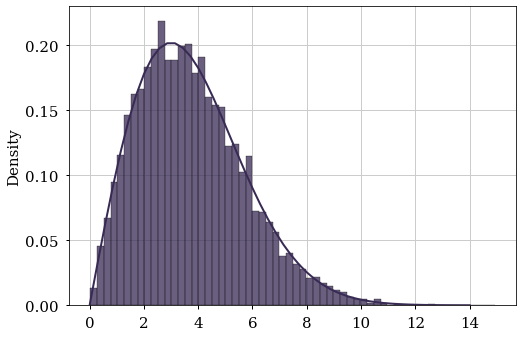

In [106]:
sigma = 3
nsamp = int(1E4)

xs = np.linspace(0, 14)
x = rayleigh.rvs(scale=sigma, size=nsamp)
ax = sns.histplot(x, stat="density")
ax.plot(xs, rayleigh.pdf(xs, scale=sigma))

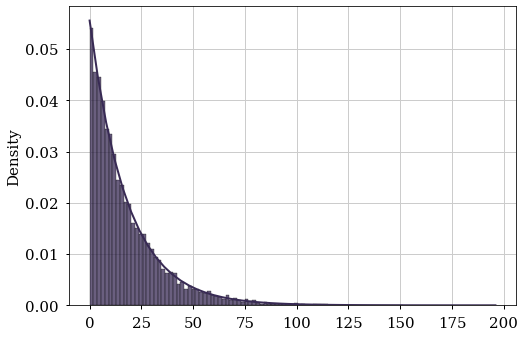

In [107]:
xs = np.linspace(0, 14**2)
x = rayleigh.rvs(scale=sigma, size=nsamp) ** 2
ax = sns.histplot(x, stat="density")
ax.plot(xs, gamma.pdf(xs, 1, scale= 2 * sigma ** 2))